<a href="https://www.kaggle.com/code/kbdharun/nyc-taxi-fare-prediction?scriptVersionId=162018213" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# New York City Taxi Fare Prediction Playground Competition 

Here we'll use a simple linear model based on the travel vector from the taxi's pickup location to dropoff location which predicts the `fare_amount` of each ride.

This kernel uses some `pandas` and mostly `numpy` for the critical work.  There are many higher-level libraries you could use instead, for example `sklearn` or `statsmodels`.  

In [1]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to

print(os.listdir('../input'))

['sample_submission.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv', 'test.csv']


### Setup training data
First let's read in our training data.  Kernels do not yet support enough memory to load the whole dataset at once, at least using `pd.read_csv`.  The entire dataset is about 55M rows, so we're skipping a good portion of the data, but it's certainly possible to build a model using all the data.

In [2]:
train_df =  pd.read_csv('../input/train.csv', nrows = 10_000_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates.  We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.

In [3]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

### Explore and prune outliers
First let's see if there are any `NaN`s in the dataset.

In [4]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


There are a small amount, so let's remove them from the dataset.

In [5]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


Now let's quickly plot a subset of our travel vector features to see its distribution.

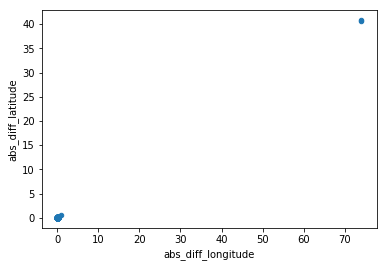

In [6]:
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city.  For reference, one degree of latitude is about 69 miles.  However, we can see the dataset has extreme values which do not make sense.  Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 2000 rows...)

In [7]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999931
New size: 9979187


### Train our model
Our model will take the form $X \cdot w = y$ where $X$ is a matrix of input features, and $y$ is a column of the target variable, `fare_amount`, for each row. The weight column $w$ is what we will "learn".

First let's setup our input matrix $X$ and target column $y$ from our training set.  The matrix $X$ should consist of the two GPS coordinate differences, plus a third term of 1 to allow the model to learn a constant bias term.  The column $y$ should consist of the target `fare_amount` values.

In [8]:
# Construct and return an Nx3 input matrix for our linear model
# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979187, 3)
(9979187,)


Now let's use `numpy`'s `lstsq` library function to find the optimal weight column $w$.

In [9]:
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[147.16176525  76.95503724   6.39545245]


These weights pass a quick sanity check, since we'd expect the first two values -- the weights for the absolute longitude and latitude differences -- to be positive, as more distance should imply a higher fare, and we'd expect the bias term to loosely represent the cost of a very short ride.

Sidenote:  we can actually calculate the weight column $w$ directly using the [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) method:
$w = (X^T \cdot X)^{-1} \cdot X^T \cdot y$

In [10]:
w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(train_X.T, train_X)), train_X.T), train_y)
print(w_OLS)

[147.16176525  76.95503724   6.39545245]


### Make predictions on the test set
Now let's load up our test inputs and predict the `fare_amount`s for them using our learned weights!

In [11]:
test_df = pd.read_csv('../input/test.csv')
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [12]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

print(os.listdir('.'))

['__notebook__.ipynb', 'submission.csv']
